# Printing and Plotting Results

Contains two sections:
1. How to create a summary table.
2. How to create plots showing the ranks of the similarity measures.

## Summary Table

This section of the notebook, creates the overview table in our paper. This code can be easily adjusted to also output more detailed tables.

In [31]:
import re
from pathlib import Path

import pandas as pd
import pandas.io.formats.style

from repsim.benchmark.paths import BASE_PATH


measure_to_abbrv = {
    "AlignedCosineSimilarity": "AlignCos",
    "CKA": "CKA",
    "ConcentricityDifference": "ConcDiff",
    "DistanceCorrelation": "DistCorr",
    "EigenspaceOverlapScore": "EOS",
    "GeometryScore": "GS",
    "Gulp": "GULP",
    "HardCorrelationMatch": "HardCorr",
    "IMDScore": "IMD",
    "JaccardSimilarity": "Jaccard",
    "LinearRegression": "LinReg",
    "MagnitudeDifference": "MagDiff",
    "OrthogonalAngularShapeMetricCentered": "AngShape",
    "OrthogonalProcrustesCenteredAndNormalized": "OrthProc",
    "PWCCA": "PWCCA",
    "PermutationProcrustes": "PermProc",
    "ProcrustesSizeAndShapeDistance": "ProcDist",
    "RSA": "RSA",
    "RSMNormDifference": "RSMDiff",
    "RankSimilarity": "RankSim",
    "SVCCA": "SVCCA",
    "SecondOrderCosineSimilarity": "2nd-Cos",
    "SoftCorrelationMatch": "SoftCorr",
    "UniformityDifference": "UnifDiff"
}


Step 1: Load all results.

In [32]:
cleaned_dfs = []
nlp_root = BASE_PATH /"paper_results" / "nlp"
for path in nlp_root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    setting = path.name.split("_")[0]

    pattern = r'(?<=_)sst2(?=_)|(?<=_)mnli(?=_)'
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
nlp_data = data


In [59]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"graph"
for path in root.glob("*.csv"):
    if path.name.endswith("backup.csv"):
        continue

    df = pd.read_csv(path, index_col=0)
    pattern = r"augmentation|label_test|layer_test|output_correlation|shortcut"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "augmentation": "aug",
        "label_test": "mem",
        "layer_test": "mono",
        "output_correlation": "correlation",
        "shortcut": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)cora(?=_)|(?<=_)flickr(?=_)|(?<=_)ogbn-arxiv(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
graph_data = data

In [60]:
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr")].groupby(["architecture", "functional_similarity_measure","similarity_measure"]).count()
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr") & (graph_data.similarity_measure == "AlignedCosineSimilarity") & (graph_data.architecture == "GCN")]

,similarity_measure,quality_measure,model,value,domain,architecture,representation_dataset,identifier,Setting,Dataset,functional_similarity_measure,corr,pval
4761,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,JSD,0.016601,0.913809
4764,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,Disagreement,-0.084083,0.582905
4767,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,AbsoluteAccDiff,-0.331839,0.025952


In [4]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"vision"
for path in root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    pattern = r"aug|mem|mono|correlation|sc"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "aug": "aug",
        "mem": "mem",
        "mono": "mono",
        "correlation": "correlation",
        "sc": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)in100(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
vision_data = data

## Clean and Pivot

Step 2: Combine data into a big dataframe, clean up column names etc., and select data to be shown in table.

In [21]:
# ----------------------------------------------------------------------------------------------------------------------
# Combine data
# ----------------------------------------------------------------------------------------------------------------------
data = pd.concat([nlp_data, graph_data, vision_data])
print(data.columns)

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

# ----------------------------------------------------------------------------------------------------------------------
# Exclude data not to be shown in table.
# ----------------------------------------------------------------------------------------------------------------------
idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] != "JSD")
data = data.loc[~idx]

idx = (data.Setting.isin(["aug", "mem", "sc"])) & (data["Quality Measure"] != "AUPRC")
data = data.loc[~idx]

idx = (data.Setting.isin(["correlation", "acc_corr"])) & (data["Quality Measure"] != "spearmanr")
data = data.loc[~idx]

idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "correlation")
data = data.loc[~idx]


# ----------------------------------------------------------------------------------------------------------------------
# Clean up names etc.
# ----------------------------------------------------------------------------------------------------------------------


def beautify_df(data):
    data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
        measure_to_abbrv
    )
    data.loc[:, "architecture"] = data["architecture"].map(
        {
            "BERT-L": "BERT",
            "GCN": "GCN",
            "GAT": "GAT",
            "GraphSAGE": "SAGE",
            "VGG11": "VGG11",
            "VGG19": "VGG19",
            "ResNet18": "RNet18",
            "ResNet34": "RNet34",
            "ResNet101": "RNet101",
            "ViT_B32": "ViT_B32",
            "ViT_L32": "ViT_L32",
            "PGNN": "P-GNN",
        }
    )
    data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
    data.loc[:, "Dataset"] = data["Dataset"].map(
        {
            "mnli_aug_rate0": "MNLI",
            "mnli_mem_rate0": "MNLI",
            "mnli": "MNLI",
            "sst2_sc_rate0558": "SST2",
            "sst2_mem_rate0": "SST2",
            "mnli_sc_rate0354": "MNLI",
            "sst2_aug_rate0": "SST2",
            "sst2": "SST2",
            "flickr": "flickr",
            "ogbn-arxiv": "arXiv",
            "cora": "Cora",
            "in100": "IN100",
        }
    )
    data.loc[:, "Setting"] = data["Setting"].map(
        {
            "aug": "Augmentation",
            "mem": "Random Labels",
            "correlation": "JSD Corr.",
            "acc_corr": "Acc Corr.",
            "mono": "Layer Mono.",
            "sc": "Shortcuts",
        }
    )
    column_order = ["Acc Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
    data.loc[:, "Setting"] = pd.Categorical(
        data["Setting"],
        categories=column_order,
        ordered=True,
    )
    data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
        {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
    )
    data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
        1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
    )  # must be run in conjunction with the above renaming

    data = data.rename(
        columns={
            "domain": "Domain",
            "architecture": "Arch.",
            "Representational Similarity Measure": "Sim Meas.",
            "Quality Measure": "Eval.",
            "Setting": "Test",
        }
    )
    data.loc[data.Test.isin(["Acc Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
    data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
    return data, column_order


data, column_order = beautify_df(data)

# ----------------------------------------------------------------------------------------------------------------------
# Create aggregated overview table
# ----------------------------------------------------------------------------------------------------------------------
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"])

pivot = pd.pivot_table(
    data.loc[idx],
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

Index(['similarity_measure', 'quality_measure', 'value', 'domain',
       'architecture', 'representation_dataset', 'identifier', 'Setting',
       'Dataset', 'functional_similarity_measure', 'corr', 'pval', 'model'],
      dtype='object')


Type      Grounding by Prediction                                          \
Test                    Acc Corr.                     JSD Corr.             
Eval.                    Spearman                      Spearman             
Domain                      Graph      Text    Vision     Graph      Text   
Dataset                    flickr      MNLI     IN100    flickr      MNLI   
Arch.                        SAGE      BERT    RNet18      SAGE      BERT   
Sim Meas.                                                                   
2nd-Cos                 -0.088933 -0.255661 -0.078977  0.153887  0.162846   
AlignCos                 0.388142  0.245970 -0.077461  0.443083  0.365349   
AngShape                 0.426746  0.275505  0.207265  0.625955  0.264032   
CKA                      0.372069  0.178528  0.356517  0.576416  0.296706   
ConcDiff                -0.059552 -0.001253 -0.106006 -0.033992  0.021212   
DistCorr                 0.359684  0.153476  0.309447  0.430698  0.392358   
EOS                      0.224374  0.027293  0.048059  0.384585  0.363109   
GULP                     0.215020 -0.009559  0.022282  0.383136  0.345191   
HardCorr                 0.322793  0.043116  0.210166  0.504743 -0.265744   
IMD                      0.369775 -0.262979  0.156438  0.306983 -0.385771   
Jaccard                  0.073518 -0.210964 -0.113982  0.421476  0.125560   
LinReg                   0.276629  0.178544  0.184734  0.477316  0.281074   
MagDiff                 -0.005929  0.217886 -0.161382  0.056126  0.011858   
OrthProc                 0.426746  0.275505  0.208847  0.625955  0.264032   
PWCCA                         NaN  0.013866 -0.022328       NaN  0.220167   
PermProc                -0.040711  0.087418  0.070011 -0.098814 -0.062055   
ProcDist                 0.012780  0.280582  0.079966 -0.179842  0.074177   
RSA                      0.300132  0.003956  0.056233  0.630435  0.268248   
RSMDiff                 -0.160611  0.300623  0.086822 -0.042029 -0.176285   
RankSim                  0.143742 -0.087022  0.071132  0.296970  0.083267   
SVCCA                   -0.119236  0.318225  0.294944  0.231621  0.466930   
SoftCorr                 0.307905  0.114250  0.268838  0.525165 -0.228458   
UnifDiff                 0.007115  0.141609 -0.184076  0.016337 -0.016733   

Type                Grounding by Design                                \
Test                      Random Labels                     Shortcuts   
Eval.                             AUPRC                         AUPRC   
Domain       Vision               Graph      Text    Vision     Graph   
Dataset       IN100              flickr      MNLI     IN100    flickr   
Arch.        RNet18                SAGE      BERT    RNet18      SAGE   
Sim Meas.                                                               
2nd-Cos   -0.127009            0.423219  0.386772  0.712253  1.000000   
AlignCos   0.075889            0.423206  1.000000  0.724314  1.000000   
AngShape   0.243874            0.433875  0.900161  0.724314  1.000000   
CKA        0.299078            0.657255  0.752692  1.000000  1.000000   
ConcDiff  -0.292885            0.569848  1.000000  0.988889  0.176244   
DistCorr   0.260211            0.427352  0.750119  1.000000  1.000000   
EOS        0.086561            0.424426  0.616949  0.837241  0.432888   
GULP       0.070619            0.424274  0.611046  0.892925  0.432888   
HardCorr   0.282872            0.457124  0.749357  0.724314  1.000000   
IMD       -0.102108            0.335412  0.727688  1.000000  0.967215   
Jaccard    0.355995            0.430100  0.685921  1.000000  0.827864   
LinReg     0.213432            0.449161  0.569724       NaN  0.609064   
MagDiff   -0.383004            0.717565  0.331188  1.000000  0.782998   
OrthProc   0.242292            0.433875  0.900161  0.724314  1.000000   
PWCCA      0.130147                 NaN  0.649802       NaN       NaN   
PermProc   0.178788            0.904040  0.436244  0.698892  1.000000   
ProcDist  

### Turn values into strings

In [8]:
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=1,)
unpivot
pivot

Type      Grounding by Prediction                                        \
Test                    Acc Corr.               JSD Corr.                 
Eval.                    Spearman                Spearman                 
Domain                      Graph   Text Vision     Graph   Text Vision   
Dataset                    flickr   MNLI  IN100    flickr   MNLI  IN100   
Arch.                        SAGE   BERT RNet18      SAGE   BERT RNet18   
Sim Meas.                                                                 
2nd-Cos                     -0.09  -0.26  -0.08      0.15   0.16  -0.13   
AlignCos                     0.39   0.25  -0.08      0.44   0.37   0.08   
AngShape                     0.43   0.28   0.21      0.63   0.26   0.24   
CKA                          0.37   0.18   0.36      0.58    0.3    0.3   
ConcDiff                    -0.06   -0.0  -0.11     -0.03   0.02  -0.29   
DistCorr                     0.36   0.15   0.31      0.43   0.39   0.26   
EOS                          0.22   0.03   0.05      0.38   0.36   0.09   
GULP                         0.22  -0.01   0.02      0.38   0.35   0.07   
HardCorr                     0.32   0.04   0.21       0.5  -0.27   0.28   
IMD                          0.37  -0.26   0.16      0.31  -0.39   -0.1   
Jaccard                      0.07  -0.21  -0.11      0.42   0.13   0.36   
LinReg                       0.28   0.18   0.18      0.48   0.28   0.21   
MagDiff                     -0.01   0.22  -0.16      0.06   0.01  -0.38   
OrthProc                     0.43   0.28   0.21      0.63   0.26   0.24   
PWCCA                         nan   0.01  -0.02       nan   0.22   0.13   
PermProc                    -0.04   0.09   0.07      -0.1  -0.06   0.18   
ProcDist                     0.01   0.28   0.08     -0.18   0.07    0.1   
RSA                           0.3    0.0   0.06      0.63   0.27   0.12   
RSMDiff                     -0.16    0.3   0.09     -0.04  -0.18  -0.41   
RankSim                      0.14  -0.09   0.07       0.3   0.08  -0.15   
SVCCA                       -0.12   0.32   0.29      0.23   0.47   0.21   
SoftCorr                     0.31   0.11   0.27      0.53  -0.23   0.45   
UnifDiff                     0.01   0.14  -0.18      0.02  -0.02  -0.34   

Type      Grounding by Design                                      \
Test            Random Labels              Shortcuts                
Eval.                   AUPRC                  AUPRC                
Domain                  Graph  Text Vision     Graph  Text Vision   
Dataset                flickr  MNLI  IN100    flickr  MNLI  IN100   
Arch.                    SAGE  BERT RNet18      SAGE  BERT RNet18   
Sim Meas.                                                           
2nd-Cos                  0.42  0.39   0.71       1.0  0.59    1.0   
AlignCos                 0.42   1.0   0.72       1.0  0.58    1.0   
AngShape                 0.43   0.9   0.72       1.0   0.6    1.0   
CKA                      0.66  0.75    1.0       1.0  0.59    1.0   
ConcDiff                 0.57   1.0   0.99      0.18  0.38   0.53   
DistCorr                 0.43  0.75    1.0       1.0  0.58    1.0   
EOS                      0.42  0.62   0.84      0.43  0.57    1.0   
GULP                     0.42  0.61   0.89      0.43  0.56    1.0   
HardCorr                 0.46  0.75   0.72       1.0  0.55   0.97   
IMD                      0.34  0.73    1.0      0.97  0.53   0.67   
Jaccard                  0.43  0.69    1.0      0.83  0.56    1.0   
LinReg                   0.45  0.57    nan      0.61  0.46   0.99   
MagDiff                  0.72  0.33    1.0      0.78  0.48   0.37   
OrthProc                 0.43   0.9   0.72       1.0   0.6    1.0   
PWCCA                     nan  0.65    nan       nan  0.56   0.99   
PermProc                  0.9  0.44    0.7       1.0  0.52   0.72   
ProcDist                 0.62  0.98   0.72       1.0  0.54    1.0   
RSA                      0.42  0.46   0.75       1.0  0.58    1.0   
RSMDiff                 

### Significance Indicators

In [22]:
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"]) & data.Test.isin(["Acc Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

def significance_via_text_style(pval):
    if pval <= 0.01:
        return [r"\underline{\underline{", r"}}"]
    if pval <= 0.05:
        return [r"\underline{", r"}"]
    return ["", ""]

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
# data_corr["val_comb"] = data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[0]) + data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[1])
data_corr

pivot_corr = data_corr.pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Domain"
).loc[:, "val_comb"]
pivot_corr

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.09$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos              0.39$^{**}$   0.25$^{\phantom{**}}$   
AngShape              0.43$^{**}$   0.28$^{\phantom{**}}$   
CKA         0.37$^{*\phantom{*}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.06$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr    0.36$^{*\phantom{*}}$   0.15$^{\phantom{**}}$   
EOS         0.22$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP        0.22$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.32$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.07$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg                0.28$^{**}$   0.18$^{\phantom{**}}$   
MagDiff    -0.01$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc              0.43$^{**}$   0.28$^{\phantom{**}}$   
PWCCA                         NaN   0.01$^{\phantom{**}}$   
PermProc   -0.04$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist    0.01$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.30$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.14$^{\phantom{**}}$  -0.09$^{\phantom{**}}$   
SVCCA      -0.12$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.31$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.01$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.31$^{*\phantom{*}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$                     NaN   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                       
Test                                                       
Eval.                                                      
Domain                       Text                  Vision  
Dataset                      MNLI                   IN100  
Arch.                        BERT     

In [19]:
# pivot.loc[:, ("Grounding by Prediction")].astype("str", copy=False)
# pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")] = pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")].astype("str")
# pivot.loc[:, ("Grounding by Prediction")].dtypes

pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.09$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos              0.39$^{**}$   0.25$^{\phantom{**}}$   
AngShape              0.43$^{**}$   0.28$^{\phantom{**}}$   
CKA         0.37$^{*\phantom{*}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.06$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr    0.36$^{*\phantom{*}}$   0.15$^{\phantom{**}}$   
EOS         0.22$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP        0.22$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.32$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.07$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg                0.28$^{**}$   0.18$^{\phantom{**}}$   
MagDiff    -0.01$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc              0.43$^{**}$   0.28$^{\phantom{**}}$   
PWCCA                         NaN   0.01$^{\phantom{**}}$   
PermProc   -0.04$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist    0.01$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.30$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.14$^{\phantom{**}}$  -0.09$^{\phantom{**}}$   
SVCCA      -0.12$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.31$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.01$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.31$^{*\phantom{*}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$                     NaN   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                      Grounding by Design  \
Test                                                            Random Labels   
Eval.                                                                   AUPRC   
Domain                       Text                  Vision               Graph   
Dataset       

Step 3: Convert into latex table.

In [20]:
styled = pd.io.formats.style.Styler(
    pivot,
    precision=2,
)

# Highlight top value
# latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
#     hrules=True,
#     position="t",
#     label="tab:result_overview",
# )
latex_str = styled.to_latex(hrules=True, position="t", label="tab:result_overview",)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# Center headers
pattern = r"\{r\}"
replacement = r"{c}"
latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# Remove measure row
latex_str.pop(11)

# Add vertical bars
line_no = 2
# line_no = 3
mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:result_overview}
\begin{tabular}{l|rrr|rrr|rrr|rrr|rrr|rrr}
\toprule
Type & \multicolumn{6}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Test & \multicolumn{3}{c}{Acc Corr.} & \multicolumn{3}{c}{JSD Corr.} & \multicolumn{3}{c}{Random Labels} & \multicolumn{3}{c}{Shortcuts} & \multicolumn{3}{c}{Augmentation} & \multicolumn{3}{c}{Layer Mono.} \\
Eval. & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{Spearman} \\
Domain & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision \\
Dataset & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 \\
Arch. & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SA

## Rankplots

Requires section above to be run as well.

In [24]:
import seaborn as sns

sns.set_theme("paper", style="white", font_scale=1.5)


Combine data similarly to before, but do not filter out specific parts.

In [25]:
data = pd.concat([nlp_data, graph_data, vision_data])
data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)
data = data.reset_index()

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = data["Quality Measure"].isin(["AUPRC", "spearmanr", "correlation"])
data = data.loc[idx]

idx = data.Setting == "correlation"
data.loc[idx, "Setting"] = data.loc[idx, "Setting"] + data.loc[idx, "Functional Similarity Measure"]

idx = ~(data.Setting == "mono")
data.loc[idx, "model"] = "agg"


data["rank"] = data.groupby(["domain", "Setting", "Dataset", "architecture", "model"], as_index=True)["value"].rank(
    ascending=False
)
data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(measure_to_abbrv)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Language", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlationJSD": "JSD Corr.",
        "correlationAbsoluteAccDiff": "Acc Corr.",
        "correlationDisagreement": "Disagr. Corr.",
        "acc_corr": "Acc Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)

data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Scenario",
    }
)

data = data.sort_values(by=["Sim Meas."])

Rank measures.

In [26]:
avg_ranks = data.groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,avg_rank,med_rank
0,Graph,2nd-Cos,7.934343,7.0
1,Graph,AlignCos,12.131313,11.0
2,Graph,AngShape,9.434343,9.0
3,Graph,CKA,11.005051,10.0
4,Graph,ConcDiff,17.449495,19.0
...,...,...,...,...
63,Vision,RSMDiff,15.876147,17.0
64,Vision,RankSim,8.599099,8.5
65,Vision,SVCCA,15.459091,16.0
66,Vision,SoftCorr,13.288288,14.5


Create plots.

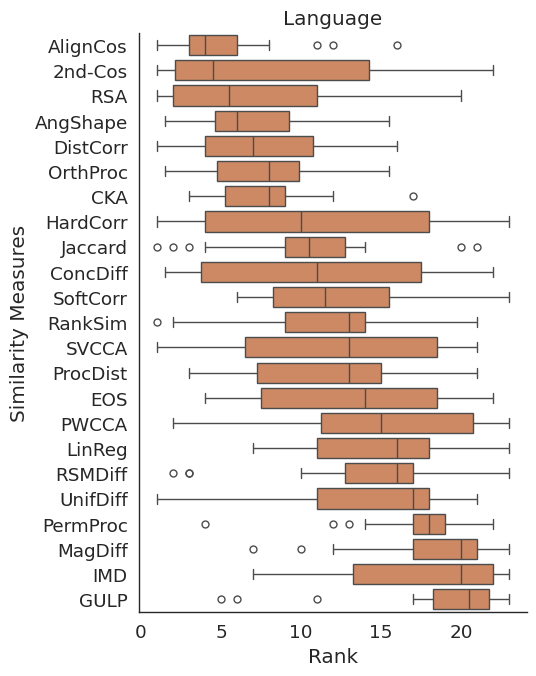

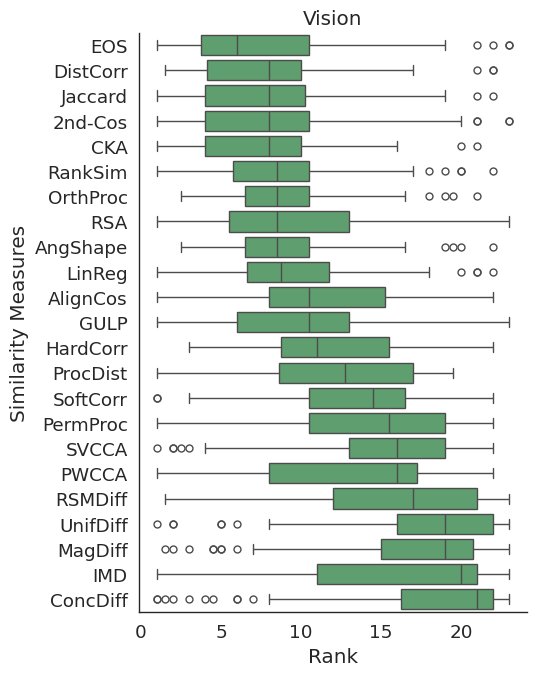

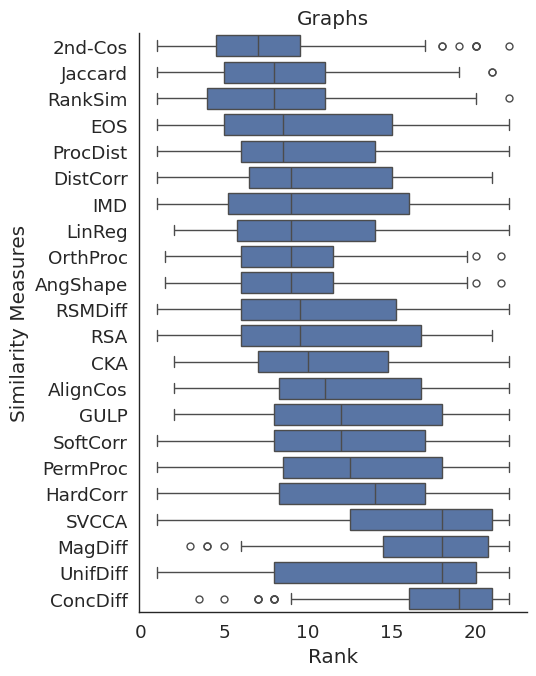

In [27]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for mod in plot_data.Modality.unique():
    g = sns.catplot(
        data=plot_data[plot_data.Modality == mod],
        x="rank",
        y="Sim Meas.",
        hue="Modality",
        kind="box",
        height=7,
        aspect=0.8,
        col="Modality",
        palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        legend=False
    )
    ax = g.axes[0, 0]
    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")
    if mod == "Graph":
        ax.set_title("Graphs")
    else:
        ax.set_title(mod)
    g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

## Rebuttal PGNN tables

In [93]:
data = graph_data.copy()

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "Disagreement")
data.loc[idx, "Setting"] = "disagr_corr"

data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
    measure_to_abbrv
)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
        "PGNN": "P-GNN",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlation": "JSD Corr.",
        "acc_corr": "Acc Corr.",
        "disagr_corr": "Disagr. Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)
column_order = ["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
data.loc[:, "Setting"] = pd.Categorical(
    data["Setting"],
    categories=column_order,
    ordered=True,
)
data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Test",
    }
)
data.loc[data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
    "Grounding by Design"
)

data = data[(~data["Eval."].isna()) & (data["Dataset"] == "Cora") & (data["Test"].isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Layer Mono."]))]

pivot = pd.pivot_table(
    data,
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot = pivot.reindex(["GAT", "GCN", "SAGE", "P-GNN"], axis="columns", level="Arch.")
pivot

# turn vals into string
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: f"{round(x, 2):.2f}")
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=1,)
unpivot


for column in pivot.columns:
    col = pivot.loc[:, column].astype("float")
    idx = col == col.max()
    pivot.loc[idx, column] = pivot.loc[idx, column].apply(lambda s: r"\textbf{" + s + "}")


# add significance indicators
idx = data["Dataset"].isin(["Cora"]) & data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
data_corr

pivot_corr = data_corr.drop_duplicates(
    subset=[
        "Sim Meas.",
        "Eval.",
        "model",
        "Modality",
        "Arch.",
        "representation_dataset",
        "identifier",
        "Test",
        "Dataset",
        "Functional Similarity Measure",
        "Type"
        ]).pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Modality"
).loc[:, "val_comb"]
pivot_corr


def floatify(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '-0.10'"""
    return s[:s.find("$")]

def separate_significance_indicator(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '$^{\phantom{**}}$'"""
    return s[s.find("$"):]


for column in pivot_corr.columns:
    col = pivot_corr.loc[:, column].apply(floatify).astype("float")
    identifiers = pivot_corr.loc[:, column].apply(separate_significance_indicator)
    idx = col == col.max()
    new_col = col.apply(lambda x: f"{x:.2f}").apply(lambda s: r"\textbf{" + s + "}") + identifiers
    pivot_corr.loc[idx, column] = new_col


pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type              Grounding by Prediction                                  \
Test                            Acc Corr.                                   
Eval.                            Spearman                                   
Modality                            Graph                                   
Dataset                              Cora                                   
Arch.                                 GAT                             GCN   
Sim Meas.                                                                   
2nd-Cos            -0.11$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   
AlignCos           -0.29$^{\phantom{**}}$          -0.33$^{*\phantom{*}}$   
AngShape           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
CKA                 0.02$^{\phantom{**}}$           0.16$^{\phantom{**}}$   
ConcDiff           -0.20$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
DistCorr            0.03$^{\phantom{**}}$           0.01$^{\phantom{**}}$   
EOS                -0.05$^{\phantom{**}}$          -0.24$^{\phantom{**}}$   
GULP               -0.12$^{\phantom{**}}$                    -0.43$^{**}$   
HardCorr           -0.14$^{\phantom{**}}$           0.11$^{\phantom{**}}$   
IMD                -0.02$^{\phantom{**}}$          -0.11$^{\phantom{**}}$   
Jaccard            -0.16$^{\phantom{**}}$           0.02$^{\phantom{**}}$   
LinReg             -0.11$^{\phantom{**}}$           0.06$^{\phantom{**}}$   
MagDiff            -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
OrthProc           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
PWCCA              -0.26$^{*\phantom{*}}$          -0.05$^{\phantom{**}}$   
PermProc           -0.26$^{\phantom{**}}$          -0.12$^{\phantom{**}}$   
ProcDist           -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
RSA                -0.28$^{\phantom{**}}$          -0.27$^{\phantom{**}}$   
RSMDiff            -0.14$^{\phantom{**}}$          -0.19$^{\phantom{**}}$   
RankSim    \textbf{0.32}$^{*\phantom{*}}$          -0.00$^{\phantom{**}}$   
SVCCA              -0.19$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
SoftCorr            0.03$^{\phantom{**}}$  \textbf{0.18}$^{\phantom{**}}$   
UnifDiff           -0.09$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   

Type                                                               \
Test                                                                
Eval.                                                               
Modality                                                            
Dataset                                                             
Arch.                                SAGE                   P-GNN   
Sim Meas.                                                           
2nd-Cos             0.04$^{\phantom{**}}$   0.15$^{*\phantom{*}}$   
AlignCos            0.13$^{\phantom{**}}$   0.05$^{\phantom{**}}$   
AngShape           -0.29$^{\phantom{**}}$             0.20$^{**}$   
CKA                -0.17$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
ConcDiff           -0.25$^{\phantom{**}}$             0.35$^{**}$   
DistCorr           -0.17$^{\phantom{**}}$   0.15$^{*\phantom{*}}$   
EOS                 0.08$^{\phantom{**}}$             0.27$^{**}$   
GULP                0.08$^{\phantom{**}}$             0.28$^{**}$   
HardCorr           -0.11$^{\phantom{**}}$             0.32$^{**}$   
IMD                -0.00$^{\phantom{**}}$  -0.16$^{*\phantom{*}}$   
Jaccard            -0.11$^{\phantom{**}}$   0.08$^{\phantom{**}}$   
LinReg             -0.21$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
MagDiff            -0.13$^{\phantom{**}}$             0.36$^{**}$   
OrthProc           -0.29$^{\phantom{**}}$             0.20$^{**}$   
PWCCA               0.07$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
PermProc   \textbf{0.18}$^{\phantom{**}}$    \textbf{0.47}$^{**}$   
ProcDist            0.01$^{\phantom{**}}$    \textbf{0.47}$^{**}$   
RSA                 0.04$^{\phant

In [94]:
len(data_corr), len(data_corr.drop_duplicates(subset=["Sim Meas.", "Eval.", "model", "Modality", "Arch.", "representation_dataset", "identifier", "Test", "Dataset", "Functional Similarity Measure", "Type"]))
# data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."]).count()[(data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."])["value"].count() > 1)]

# data_corr[(data_corr["Sim Meas."] == "IMD") & (data_corr["Dataset"] == "Cora") & (data_corr["Arch."] == "GAT") & (data_corr["Test"] == "JSD Corr.")]

latex_str = pivot.to_latex()
print(latex_str)

\begin{tabular}{lllllllllllllllllllll}
\toprule
Type & \multicolumn{12}{r}{Grounding by Prediction} & \multicolumn{8}{r}{Grounding by Design} \\
Test & \multicolumn{4}{r}{Acc Corr.} & \multicolumn{4}{r}{Disagr. Corr.} & \multicolumn{4}{r}{JSD Corr.} & \multicolumn{8}{r}{Layer Mono.} \\
Eval. & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Conformity Rate} & \multicolumn{4}{r}{Spearman} \\
Modality & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} \\
Dataset & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} \\
Arch. & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN \\
Sim Meas. &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
2nd-Cos & -0.11$^{

## Survey Paper Summary

In [28]:
data

,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank
8400,2300,2nd-Cos,AUPRC,1.000000,Vision,RNet101,ColorDot_0_ImageNet100DataModule,Shortcut,Shortcuts,IN100,NaN,NaN,NaN,agg,6.5
3013,1863,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_0,9.0
3015,1865,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_1,9.0
3019,1869,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_3,9.0
3021,1871,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_4,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3704,2554,UnifDiff,Spearman,0.212385,Graph,GAT,flickr,Normal,JSD Corr.,flickr,JSD,0.212385,0.161314,agg,3.0
5465,4315,UnifDiff,Spearman,0.269697,Graph,SAGE,cora,Normal,JSD Corr.,Cora,JSD,0.269697,0.073192,agg,8.0
5468,4318,UnifDiff,Spearman,0.161134,Graph,SAGE,cora,Normal,Disagr. Corr.,Cora,Disagreement,0.161134,0.290314,agg,8.0
3103,1953,UnifDiff,Spearman,0.666667,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_0,19.0


In [29]:
avg_ranks = data.groupby(["Scenario","Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Scenario,Sim Meas.,avg_rank,med_rank
0,Acc Corr.,2nd-Cos,14.500000,16.50
1,Acc Corr.,AlignCos,11.972222,10.75
2,Acc Corr.,AngShape,11.527778,10.75
3,Acc Corr.,CKA,10.972222,9.50
4,Acc Corr.,ConcDiff,13.388889,17.00
...,...,...,...,...
156,Shortcuts,RSMDiff,12.843750,13.00
157,Shortcuts,RankSim,7.823529,7.00
158,Shortcuts,SVCCA,16.941176,20.00
159,Shortcuts,SoftCorr,13.882353,16.00


In [30]:
data.groupby(["Scenario","Sim Meas."])["rank"].max().loc["JSD Corr."]

Sim Meas.
2nd-Cos     23.0
AlignCos    21.0
AngShape    22.0
CKA         21.0
ConcDiff    22.0
DistCorr    17.0
EOS         21.0
GULP        23.0
HardCorr    22.0
IMD         23.0
Jaccard     18.0
LinReg      18.0
MagDiff     22.0
OrthProc    21.0
PWCCA       22.0
PermProc    22.0
ProcDist    22.0
RSA         21.0
RSMDiff     23.0
RankSim     20.0
SVCCA       21.0
SoftCorr    21.0
UnifDiff    22.0
Name: rank, dtype: float64

In [31]:
avg_ranks.pivot_table(values="avg_rank", index="Sim Meas.", columns="Scenario")

Scenario,Acc Corr.,Augmentation,Disagr. Corr.,JSD Corr.,Layer Mono.,Random Labels,Shortcuts
Sim Meas.,,,,,,,
2nd-Cos,14.500000,5.166667,10.222222,10.222222,7.120000,12.333333,4.794118
AlignCos,11.972222,8.666667,11.055556,11.222222,11.972000,9.777778,6.735294
AngShape,11.527778,10.166667,9.583333,8.305556,8.184000,9.777778,7.906250
CKA,10.972222,8.805556,8.944444,9.611111,8.875000,7.416667,8.588235
ConcDiff,13.388889,15.833333,16.944444,17.444444,18.676000,9.388889,18.937500
DistCorr,11.222222,7.972222,8.333333,8.277778,8.560484,7.416667,8.117647
EOS,9.111111,12.055556,14.055556,12.166667,5.700000,17.500000,13.176471
GULP,10.944444,12.666667,14.222222,11.833333,10.404000,18.555556,14.406250
HardCorr,11.055556,15.444444,11.722222,11.666667,12.112000,11.916667,14.205882


In [32]:
avg_ranks.to_csv("ranks_per_test.csv")

Text(-47.83055555555555, 0.5, 'Similarity Measures')

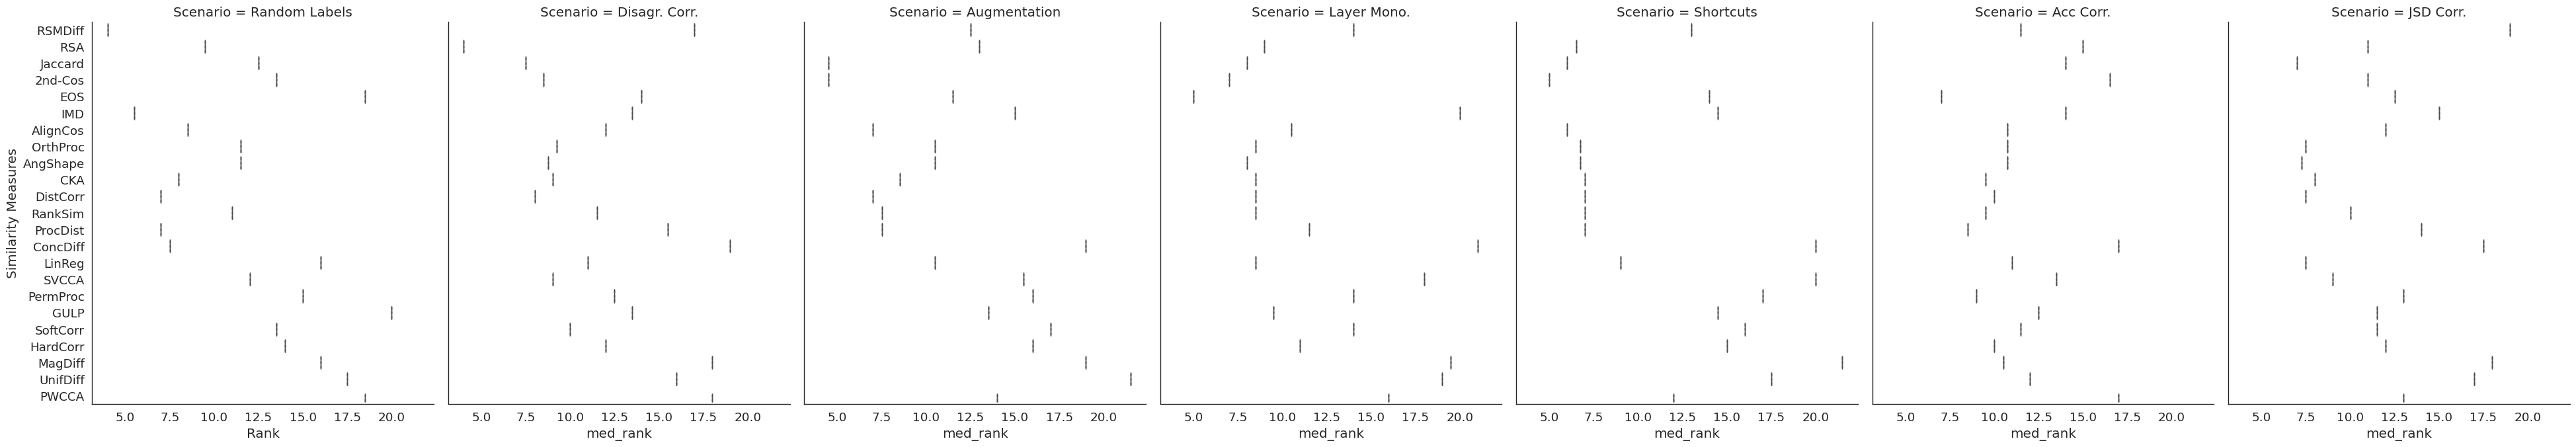

In [33]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
g = sns.catplot(
    data=plot_data,
    x="med_rank",
    y="Sim Meas.",
    hue="Modality",
    kind="box",
    height=7,
    aspect=0.8,
    col="Scenario",
    palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
    legend=False
)
ax = g.axes[0, 0]
ax.set_xlabel("Rank")
ax.set_ylabel("Similarity Measures")